<a href="https://colab.research.google.com/github/adidror005/youtube-videos/blob/main/Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal of Video
#### 1. Embeddings Overview:

* Embeddings represent data as points in a space where the locations are semantically meaningful.

#### 2. Show Mininimal RAG (Retrieval-Augmented Generation) application of embeddings
* RAG enhances the accuracy and reliability of LLMs by incorporating facts from external sources. LLMs are only trained up to a certain point and lack real-time information, as well as access to external news or documents necessary for precise answers.

#### 3. Visualize Embeddings in 2D with PCE

#### 4. Apply Embeddings to sentiment analysis text classification on the alpha vantage dataset used in my other videos and compare model with Naive Bayes baseline.

* There are many embedding models available open source and closed source usually called from a hosted API.

* Will use voyageai embeddings for Parts 1-3 since they are #1 in the Hugging face leaderboard! https://huggingface.co/spaces/mteb/leaderboard
* We will use an LLM from Open AI
* We will use openai embeddings for Part 4.

* In future videos I will talk about google's gemeni embeddings in the context of google's Vertex AI and also open source embeddings on HuggingFace.



### Embeddings

#### Overview

* Sentence/document embeddings are vector representations of text that capture semantic meaning, enabling efficient comparison and analysis of linguistic content.

* Semantics is the study of meaning in language.

* The pairwise distance of similar documents or sentences is smaller.

Example: The pairwise distance between "Judge nixes Elon Musk's compenation package" and "Elon musk loses 56 billion dollars" should me more similary to eachother than to "Meta to release Llama 3".

### Critical Use in RAG:
* Retrieval-Augmented Generation (RAG) optimizes large language model (LLM) output by referencing authoritative external knowledge bases before generating responses, with embeddings being crucial for accurately matching queries to relevant documents, enhancing relevance, accuracy, and usefulness without needing retraining.

* When a query is received, its embedding is compared to the precomputed document embeddings using similarity metrics such as cosine similarity.

###### Typical Rag Stack (credit to voyagai)
![img](https://files.readme.io/62f4950-rag.png)


### How are sentence embeddings computed?

* Simple old method: Sum/mean individual word embeddings (word2vec, GloVe, etc.). Not so great since order matters.

* This isn't ideal since say a work like "stock" can refer to a piece of a company or inventory, depending on the sentence and context of surrounding words.

* Modern method: Use Transformer neural networks to learn context-aware representations of each word and then take an average of these context-aware embeddings.

### How are sentence embeddings learned?

**Contrastive Learning**.
* Pretrain a transformer on a large amount of unlabeled text data from the internet or other sources.
* Find a dataset of similar sentences and tune the neural network to move the embeddings of similar sentences together and move dissimilar sentences apart.
* If the goal is a QA system, you can also declare that the question and its corresponding answer are similar. This causes the neural network to push the answer embedding closer to the embedding of the question. Dissimilar pairs are randomly selected pairs of sentences. This is still an active topic and improving every few months.
* Embeddings are computed for each subword or token/byte level as opposed to word level. This helps the algorithm work for novel and misspelled words.

### How is performance measured?

* Performance of sentence embeddings is typically measured by evaluating their ability to perform well on various downstream tasks, such as
  - semantic similarity
  - sentence classification
  - question answering.
* For semantic similarity, a common evaluation metric is Spearman's rank correlation coefficient between the cosine similarity of sentence embeddings and human judgments.

### Some other applications of embeddings:
* Classification
* Clustering
* Outlier Detection
* Semantic Search
* Recommendations


## Installs

In [ ]:
!pip install voyageai openai

### **Imports**

In [ ]:
## Keras for NN classfication model
import keras
import numpy as np
import pandas as pd
from keras import layers


# Used to securely store your API key
from google.colab import userdata


# Plotting Library
import matplotlib.pyplot as plt
import plotly.express as px

# Sklearn PCA library for vizualizing the embeddings
from sklearn.decomposition import PCA

# Sklearn cosine similarity for finding similar embeddings/documents similar to queries
from sklearn.metrics.pairwise import cosine_similarity

# Sklearn Evaluation Metrics
from sklearn.metrics import confusion_matrix
import sklearn.metrics as skmetrics
from sklearn.metrics import classification_report, accuracy_score,balanced_accuracy_score

# Naive Bayes for Baseline Classification Model Comparison
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# We will use openai for the LLM and voyageai + openai for the embeddings
import voyageai
from openai import OpenAI

# For displaying the youtube video
from IPython.display import YouTubeVideo


### Get Voyageai API Key
* https://dash.voyageai.com


In [ ]:
voyageai_api_key = userdata.get('VOYAGEAI_API_KEY')
vo = voyageai.Client(api_key=voyageai_api_key)

### Documents

In [ ]:
documents  = ["Tesla Bull Gary Black Says 'Likely' Approval Of Elon Musk's $56B Pay Package Is 'Next Major Catalyst' For The Company",
 "'In Tesla Autopilot probe, US prosecutors focus on securities, wire fraud' -Reuters",
 "Elon Musk Dispatches Tesla's 'Fireman' To China Amid Slowing Sales; Tom Zhu, One Of The Three Executives Named On Tesla's Website, Comes Back To China As Carmaker Seeks To Launch Autopilot Features There",
 'Thanks To Apple, This Analyst Is Optimistic On ARM, Microchip Technology And More Ahead Of Earnings',
 "Tesla's Top HR Executive Allie Arebalo Has Left The Company",
 "Tesla Says 'We recently undertook a cost-cutting exercise to increase operational efficiency. We also remain committed to company-wide cost reduction, including reducing COGS per vehicle.'",
 "'Tesla aims to cut 400 jobs in Germany via voluntary program' -Reuters",
 'PepsiCo Executive Says Put 36 Tesla Semis On The Road To Haul Chips And Soda, Had Planned To Have 100 In Use By 2023; Spokesperson Says Tesla Semi Plans Can Shift When Technology And The Need To Establish Infrastructure Is Involved',
 "Tesla Board's Credibility At Stake With $56B Elon Musk Pay Package Vote, Says Ross Gerber: 'Super Grateful For Tesla As An Investment'",
 'Citron Research Posts On X "$TSLA If Elon Musk deserves $47 bil for a job well done and the Musk premium on the stock...than which high profile CEO deserves to give back his G550, Yacht, and egrigous pay package for being the worst CEO of the past 10 years?  If this CEO stepped down his stock would be up 50% in one day?  Hint...a former Citron short"',
 "Microsoft's custom Cobalt chips will come to Azure next week - TechCrunch",
 'Recursion Pharmaceuticals Stock Surges 10% As Nvidia-Powered Supercomputer Completion Sparks Investor Optimism',
 'Recursion Announces Completion of NVIDIA-Powered BioHive-2 AI Pharma Supercomputer',
 'NVIDIA Launches Nine Grace Hopper-Powered Supercomputers Globally, Advancing Scientific Research',
 "'US to revoke licences for supply of chips to China's Huawei' -Financial Times",
 "Nvidia Executive Meets Vietnam's Minister On Cooperation",
 "Nvidia Joins Forces with Japan's Tech Institute for Hybrid Supercomputer Project",
 'Rivian Automotive shares are trading lower after the company reported worse-than-expected Q1 EPS results',
 'Rivian shares are trading higher following a report suggesting Apple is mulling a potential partnership with the company.',
 "Amazon's Smashing Q1 Financials Show The Power Of A Good And Well Executed Strategy",
 'Bernstein Maintains Outperform on Meta Platforms, Lowers Price Target to $565',
 'Rosenblatt Maintains Buy on Meta Platforms, Raises Price Target to $562',
 "Meta: 'We anticipate our full-year 2024 capital expenditures will be in the range of $35-40 billion, increased from our prior range of $30-37 billion as we continue to accelerate our infrastructure investments to support our artificial intelligence (AI) roadmap. '",
 'Meta Platforms Q1 2024 GAAP EPS $4.71 Beats $4.33 Estimate, Sales $36.455B Beat $36.156B Estimate',
 'Microsoft Boosts AI Arsenal With Former Meta Executive Jason Taylor',
 "Jack Ma Backed Ant Group's Alipay+ Broadens Payment Reach Across Continents: How It's Shaping Global Commerce?",
 "Mastercard Targets Over a Billion Users in China - Joins with Alibaba's Ant Group Affiliate Alipay for Instant Cross-Border Payments",
 "Amazon's Smashing Q1 Financials Show The Power Of A Good And Well Executed Strategy",
 'Microsoft Boosts AI Arsenal With Former Meta Executive Jason Taylor',
 'Reuters Reported Google, Intel, Qualcomm Executives Say They Plan To Battle Nvidia AI Dominance Through UXL Foundation']

### Vectorize/embed the documents
* For document use input_type = 'document'
* For query use input_type = 'query'

In [ ]:
document_embeddings=vo.embed(documents,model='voyage-large-2-instruct',input_type='document').embeddings

In [ ]:
len(document_embeddings)

30

In [ ]:
len(document_embeddings[0])

1024

# A minimalist retrieval system

The main feature of the embeddings is that the cosine similarity between two embeddings captures the semantic relatedness of the corresponding original passages. This allows us to use the embeddings to do semantic retrieval / search.

Suppose the user sends a "query" (e.g., a question or a comment) to the chatbot:

In [ ]:
query = "What is the status of Elon's 2018 comp plan?"

# Get the embedding of the query
* input_type = 'query'!
* Make sure you use same model. If you use different model it gives bad results.

In [ ]:
query_embedding = vo.embed([query], model="voyage-large-2-instruct", input_type="query").embeddings[0]

**Cosine similarity** can beused to measure the similarity between two vectors like the query embedding and the document embedding. It measures the cosine of the angle between two vectors, indicating their directional alignment.


**Nearest neighbor Search:** We can find a few closest embeddings in the documents embeddings based on the cosine similarity, and retrieve the corresponding document using the nearest_neighbors function.





In [ ]:
def k_nearest_neighbors(query_embedding, documents_embeddings, k=5):
  query_embedding = np.array(query_embedding) # convert to numpy array
  documents_embeddings = np.array(documents_embeddings) # convert to numpy array

  # Reshape the query vector embedding to a matrix of shape (1, n) to make it compatible with cosine_similarity
  query_embedding = query_embedding.reshape(1, -1)

  # Calculate the similarity for each item in data
  cosine_sim = cosine_similarity(query_embedding, documents_embeddings)

  # Sort the data by similarity in descending order and take the top k items
  sorted_indices = np.argsort(cosine_sim[0])[::-1]

  # Take the top k related embeddings
  top_k_related_indices = sorted_indices[:k]
  top_k_related_embeddings = documents_embeddings[sorted_indices[:k]]
  top_k_related_embeddings = [list(row[:]) for row in top_k_related_embeddings] # convert to list

  return top_k_related_embeddings, top_k_related_indices

#### Use the nearest neighbor algorithm to find the documents with the highest similarity


In [ ]:
retrieved_embd, retrieved_embd_index = k_nearest_neighbors(query_embedding, document_embeddings, k=5)

In [ ]:
retrieved_docs = [documents[index] for index in retrieved_embd_index]

for i,doc in enumerate(retrieved_docs):
    print(f"Document {i+1}: {doc}")

Document 1: Tesla Board's Credibility At Stake With $56B Elon Musk Pay Package Vote, Says Ross Gerber: 'Super Grateful For Tesla As An Investment'
Document 2: Citron Research Posts On X "$TSLA If Elon Musk deserves $47 bil for a job well done and the Musk premium on the stock...than which high profile CEO deserves to give back his G550, Yacht, and egrigous pay package for being the worst CEO of the past 10 years?  If this CEO stepped down his stock would be up 50% in one day?  Hint...a former Citron short"
Document 3: Tesla Bull Gary Black Says 'Likely' Approval Of Elon Musk's $56B Pay Package Is 'Next Major Catalyst' For The Company
Document 4: Tesla's Top HR Executive Allie Arebalo Has Left The Company
Document 5: Tesla Says 'We recently undertook a cost-cutting exercise to increase operational efficiency. We also remain committed to company-wide cost reduction, including reducing COGS per vehicle.'


### Rerankers

We can improve our embedding-based retrieval by using rerankers. After the retriever pulls documents from the vector store, the reranker assesses and orders these documents based on their semantic relevance to the query. This process results in a smaller, more relevant set of documents for the generative model.


##### Key Differences with Retriever

###### Speed vs. Precision:
- The retriever is optimized for speed, ensuring that the initial filtering process is quick.
- The reranker focuses on precision, spending more computational resources to fine-tune the relevance of the documents.

###### Breadth vs. Depth:
- The retriever casts a wide net to capture all potentially relevant documents.
- The reranker dives deeper into the content to ensure the selected documents are highly relevant.

###### Model Complexity:
- The retriever often uses simpler models (e.g., nearest neighbor search in embedding space).
- The reranker uses more complex models (e.g., BERT, RoBERTa) that understand context and semantics better.


![img](https://files.readme.io/d6f03ee-rag-reranker.png) (From voyagai)

In [ ]:
documents_reranked = vo.rerank(query, retrieved_docs, model="rerank-lite-1", top_k=3)

In [ ]:
for r in documents_reranked.results:
    print(f"Document: {r.document}")
    print(f"Relevance Score: {r.relevance_score}")
    print(f"Index: {r.index}")
    print()


Document: Tesla Bull Gary Black Says 'Likely' Approval Of Elon Musk's $56B Pay Package Is 'Next Major Catalyst' For The Company
Relevance Score: 0.5234375
Index: 2

Document: Tesla Says 'We recently undertook a cost-cutting exercise to increase operational efficiency. We also remain committed to company-wide cost reduction, including reducing COGS per vehicle.'
Relevance Score: 0.421875
Index: 4

Document: Tesla Board's Credibility At Stake With $56B Elon Musk Pay Package Vote, Says Ross Gerber: 'Super Grateful For Tesla As An Investment'
Relevance Score: 0.4140625
Index: 0



### A Minimalist RAG Chatbot

- **Overview**: The Retrieval-Augmented Generation (RAG) chatbot merges retrieval-based and generative methods for enhanced responses.
- **Functionality**:
  - **Retrieval**: Utilizes large text corpora to find relevant documents.
  - **Generation**: Uses language models like GPT-4 to generate tailored replies based on retrieved documents.
- **Process**:
  - Implement a semantic search system (with or without a reranker).
  - Retrieve the most relevant document (retrieved_doc).
  - Use a text generation model (e.g., GPT-4) to craft a response based on the query and retrieved document.


### Get openai api key: (NOTE API CALLS COST MONEY!)
https://platform.openai.com/api-keys

##### Load openai api key

In [ ]:
api_key=userdata.get('OPEN_AI_KEY')

##### Initialize OpenAI client


In [ ]:
client = OpenAI(api_key=api_key)

#### Take the retrieved document and use it as a prompt for the text generation model


In [ ]:
documents_reranked.results[0].document

"Tesla Bull Gary Black Says 'Likely' Approval Of Elon Musk's $56B Pay Package Is 'Next Major Catalyst' For The Company"

In [ ]:
prompt = f"Based on the information: '{documents_reranked.results[0].document}', generate a response of {query}"

response = client.chat.completions.create(
    model="gpt-4-1106-preview",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt},
    ],
)

print(response.choices[0].message.content)

Based on the information provided, it appears that Gary Black, known for his bullish stance on Tesla, suggests that the likely approval of Elon Musk's compensation package is expected to be a significant positive event for the company. However, the statement provided does not indicate the current status of Elon Musk's 2018 compensation plan.

Typically, high-profile compensation packages like Musk's are subject to approval by shareholders and may involve numerous performance milestones that the executive must meet to receive the full benefit of the package. Since the statement references a 'likely' approval, one can infer that the package has either not been fully approved or that certain conditions are expected to be met in the near future.

To know the exact status of Elon Musk's 2018 compensation plan, one would need to refer to official Tesla company announcements, SEC filings, or credible news reports from the time around your knowledge cutoff date. These sources would be able to 

### Visualize Embeddings
* In 2D with PCA
* Can use TSNE or something more sophisticated, but this is ok for now

### Perform PCA for 2D visualization


In [ ]:
PCA_model = PCA(n_components = 2)
PCA_model.fit(document_embeddings)
new_values = PCA_model.transform(document_embeddings)

#### Vizualize with Plotly

In [ ]:
new_values_df=pd.DataFrame(new_values,columns=['x','y'])
new_values_df['text']=documents
px.scatter(new_values_df,x='x',y='y',hover_name='text')

### Can also use the Embeddings for Clustering/Classification.

Let's do sentiment analysis classification

### Youtube Video Describing How to get Dataset
* Only really need first 3 mins of video

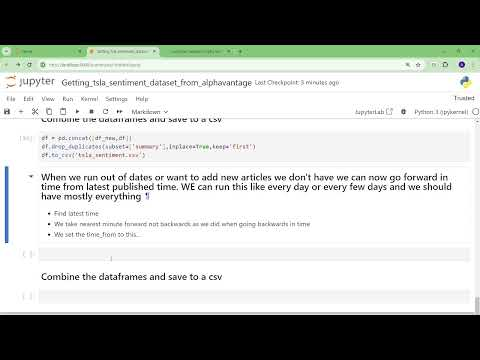

In [ ]:
YouTubeVideo('ascf3y7zSaY')

#### Load Alpha vantage labeled sentiment dataset with Pandas
* Encode label as integer since this is needed for ML classification algorithms


In [ ]:
df = pd.read_csv('tsla_sentiment_new.csv')
df['label']=df['label'].astype('category')
df['target']=df['label'].cat.codes


#### Create map from Integer Encoded Labels to Text Labels
* For later visualization

In [ ]:
display_labels={i:l for i,l in enumerate(df['label'].cat.categories)}

#### Embed the summary column with OpenAI ADA embedding
* We already defined and authenticated openai api client above.

In [ ]:
def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [ ]:
df['ada_embedding'] = df.summary.apply(lambda x: get_embedding(x, model='text-embedding-3-small'))

In [ ]:
df['ada_embedding']

0       [0.049987971782684326, -0.027003755792975426, ...
1       [0.013754896819591522, 0.017763862386345863, -...
2       [0.007476717699319124, -0.056496426463127136, ...
3       [0.041611988097429276, -0.007007290609180927, ...
4       [0.011668876744806767, -0.0468851663172245, -0...
                              ...                        
5158    [0.03744158893823624, -0.05438670143485069, -0...
5159    [-0.013495557010173798, -0.018925994634628296,...
5160    [0.020004956051707268, -0.03857302665710449, -...
5161    [-0.05978287756443024, -0.01372792012989521, -...
5162    [-0.011097131296992302, -0.00625822925940156, ...
Name: ada_embedding, Length: 5163, dtype: object

In [ ]:
len(df['ada_embedding'].iloc[0])

1536

### Can save the embeddings with rest of dataframe to CSV

In [ ]:
df.to_csv('tsla_sentiment_with_embeddings_new.csv',index=False)

### If already computed embeddings an load from csv can do this to load

In [ ]:
df_reloaded = pd.read_csv("tsla_sentiment_with_embeddings_new.csv")
df_reloaded['ada_embedding'] = df_reloaded['ada_embedding'].apply(eval).apply(np.array)

### Split into train/val/test over time as in my other LLM videos
* First 60 pct train
* Next 20 pct val
* Last 20 pct test

In [ ]:
train_end_point = int(df.shape[0]*0.6)
val_end_point = int(df.shape[0]*0.8)
df_train = df.iloc[:train_end_point,:]
df_val = df.iloc[train_end_point:val_end_point,:]
df_test = df.iloc[val_end_point:,:]
print(df_train.shape, df_test.shape, df_val.shape)



(3097, 19) (1033, 19) (1033, 19)


#### Fit a Simple Multi-Layer Perceptron Neural Network with Keras with
* Inputs: embeddings
* Outputs: sentiment of Bearish, Bullish,or Neutral

#### First Split the x and y components of the train, validation, and test subsets.


In [ ]:
# Split the x and y components of the train and validation subsets.
y_train = df_train['target']
x_train = np.stack(df_train['ada_embedding'])

y_val = df_val['target']
x_val = np.stack(df_val['ada_embedding'])

y_test = df_test['target']
x_test = np.stack(df_test['ada_embedding'])



In [ ]:
x_train.shape

(3097, 1536)

#### Define the Neural Network in Keras with Hyperparams

In [ ]:
NUM_EPOCHS = 20
BATCH_SIZE = 32

model = keras.Sequential([layers.Dense(32, activation='relu'),
                          layers.Dropout(.2),
                          layers.Dense(3, activation='sigmoid')])


model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   optimizer = keras.optimizers.Adam(learning_rate=0.001),
                   metrics=['accuracy'])

# Train the model for the desired number of epochs.
callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

history = model.fit(x=x_train,
                         y=y_train,
                         validation_data=(x_val, y_val),
                         callbacks=[callback],
                         batch_size=BATCH_SIZE,
                         epochs=NUM_EPOCHS,)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



97/97 [==============================] - 1s 5ms/step - loss: 1.0050 - accuracy: 0.4759 - val_loss: 0.9340 - val_accuracy: 0.5460
Epoch 2/20
97/97 [==============================] - 0s 4ms/step - loss: 0.9219 - accuracy: 0.5563 - val_loss: 0.8827 - val_accuracy: 0.5924
Epoch 3/20
97/97 [==============================] - 0s 3ms/step - loss: 0.8845 - accuracy: 0.5706 - val_loss: 0.8646 - val_accuracy: 0.5934
Epoch 4/20
97/97 [==============================] - 0s 3ms/step - loss: 0.8593 - accuracy: 0.5938 - val_loss: 0.8654 - val_accuracy: 0.6060
Epoch 5/20
97/97 [==============================] - 0s 3ms/step - loss: 0.8427 - accuracy: 0.6135 - val_loss: 0.8680 - val_accuracy: 0.5828
Epoch 6/20
97/97 [==============================] - 0s 3ms/step - loss: 0.8251 - accuracy: 0.6122 - val_loss: 0.8680 - val_accuracy: 0.5895
Epoch 7/20
97/97 [==============================] - 0s 3ms/step - loss: 0.8163 - accuracy: 0.6280 - val_loss: 0.8597 - val_accuracy: 0.5954
Epoch 8/20
97/97 [=============

#### Plot the training history along with validation metrics after each epoch

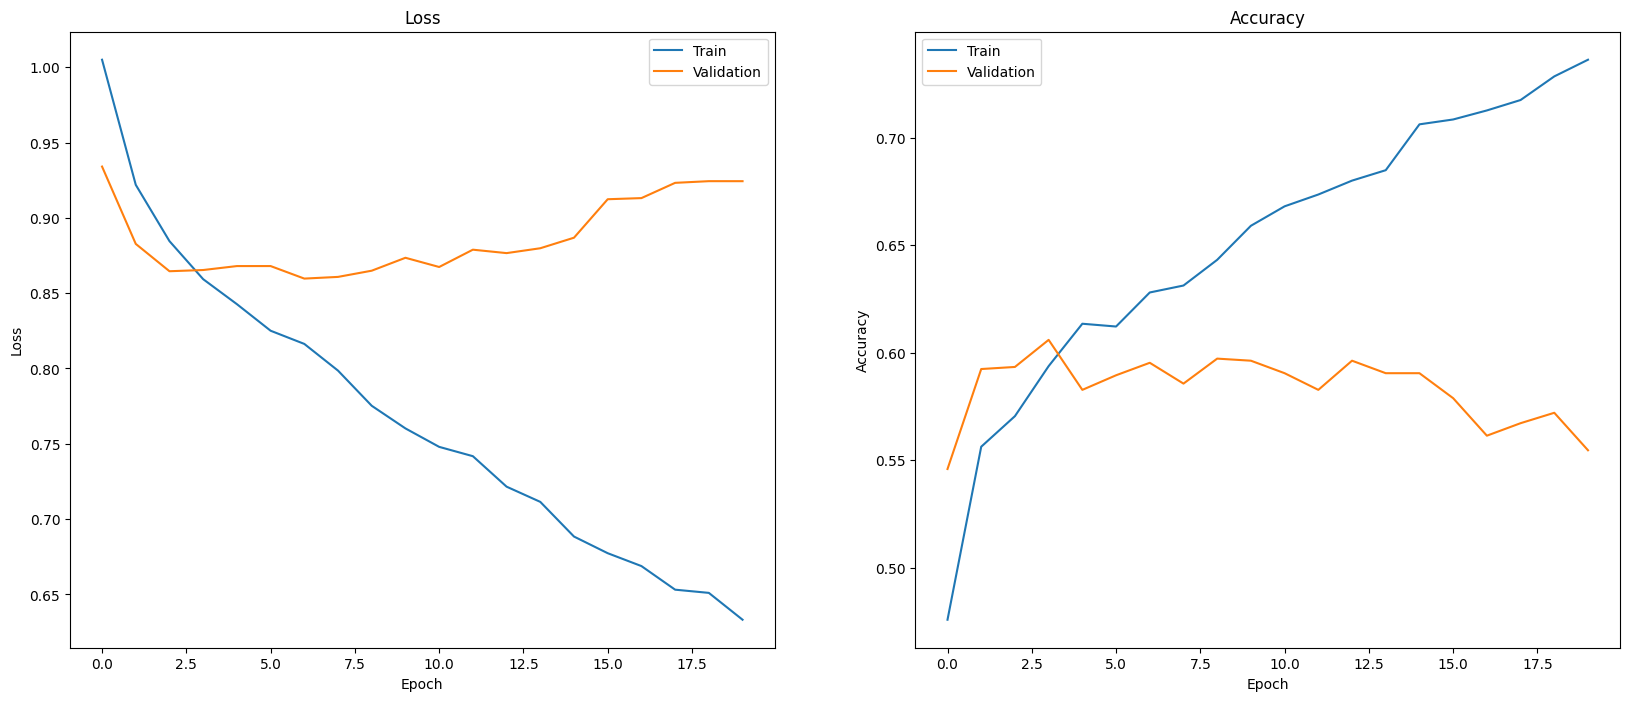

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_size_inches(20, 8)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

### Make Predictions on the test set and then evaluate the model and compute the confusion matrix

In [ ]:
model.predict(x_test)

33/33 [==============================] - 1s 11ms/step


array([[0.4210343 , 0.7009009 , 0.20527358],
       [0.21364644, 0.8818012 , 0.15804496],
       [0.07908794, 0.5403781 , 0.78258854],
       ...,
       [0.17192541, 0.6249924 , 0.5914362 ],
       [0.4970439 , 0.4659392 , 0.37192106],
       [0.21582529, 0.50841206, 0.55981785]], dtype=float32)

In [ ]:
y_hat=model.predict(x_test).argmax(axis=1)

33/33 [==============================] - 0s 2ms/step


### Evaluate the model

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_hat)}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_hat)}")
print(classification_report(y_test, y_hat, target_names=display_labels.values()))

Accuracy: 0.5314617618586641
Balanced Accuracy: 0.5100301055858405
              precision    recall  f1-score   support

    Negative       0.45      0.34      0.39       179
     Neutral       0.58      0.46      0.51       499
    Positive       0.52      0.73      0.61       355

    accuracy                           0.53      1033
   macro avg       0.52      0.51      0.50      1033
weighted avg       0.53      0.53      0.52      1033



In [ ]:
cm = confusion_matrix(y_test, y_hat)
cm

array([[ 61,  86,  32],
       [ 60, 228, 211],
       [ 14,  81, 260]])

### Display the confusion Matrix in a Pretty Way

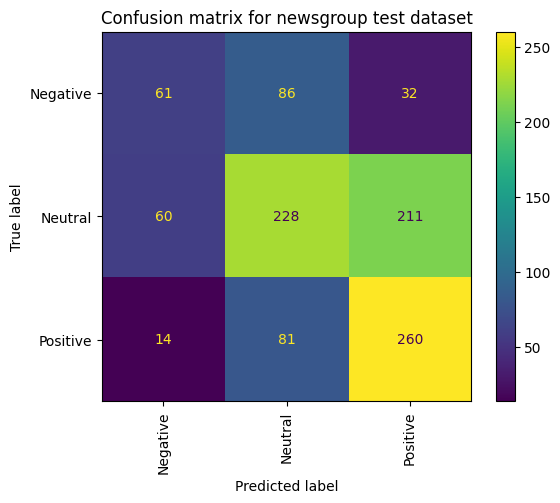

In [ ]:
disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels.values())
disp.plot(xticks_rotation='vertical')
plt.title('Confusion matrix for newsgroup test dataset');
plt.grid(False)

### Compare to a Naive Bayes Benchmark

Accuracy: 0.48693126815101645
Balanced Accuracy: 0.41494531539539325
              precision    recall  f1-score   support

    Negative       0.34      0.10      0.16       179
     Neutral       0.52      0.55      0.53       499
    Positive       0.46      0.60      0.52       355

    accuracy                           0.49      1033
   macro avg       0.44      0.41      0.40      1033
weighted avg       0.47      0.49      0.46      1033



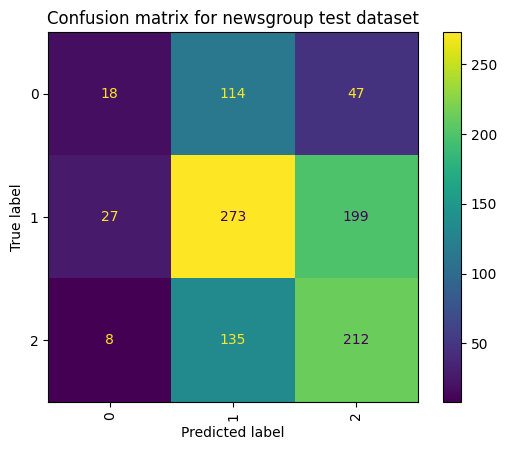

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),  # Convert text to a matrix of token counts
    ('clf', MultinomialNB())  # Naive Bayes classifier
])

# Train the model
pipeline.fit(df_train['summary'],df_train['target'])

# Predict the test set
y_hat = pipeline.predict(df_test['summary'])
y_test = df_test.target
# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_hat)}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_hat)}")
print(classification_report(y_test, y_hat, target_names=display_labels.values()))

cm = confusion_matrix(y_test, y_hat)

disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)
disp.plot(xticks_rotation='vertical')
plt.title('Confusion matrix for newsgroup test dataset');
plt.grid(False)

### Reference
* https://www.deeplearning.ai/
* https://docs.voyageai.com/docs/quickstart-tutorial